#  **Spark SQL Application for NYSE Data conversion**

## Overview
We have collected data in google cloud storage which is in CSV format. Now we want to process it and store it in a databse in table format.
we will be creating a python file which contain all queries and using shell script file we will run the python file.


### Prerequisite required
1. Create databrics Worksapce on GCP
2. Setup Databrics CLI on your PC
3. Connect to GCP
4. Have data stored in google cloud filestore.
5. connect to GCP databric using CLI and continue with instruction.


Diagram  
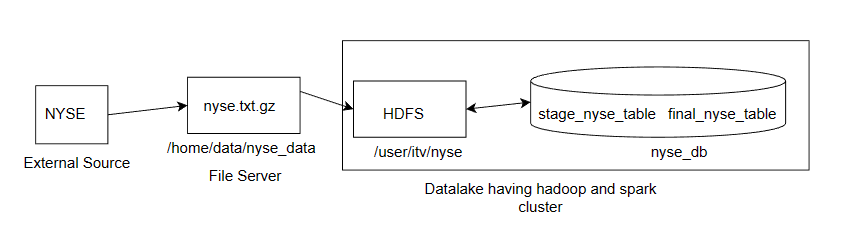

**HDFS** stands for “Hadoop Distributed File System” and is a decentralized file system that stores data across multiple computers in a cluster.\
hdfs - using this we can run command on files, data stored in hdfs.


In CLI run the below commands.

In [ ]:
hdfs -ls /user/itv/nyse
hdfs dfs -mkdir -p /user/itv/nyse
hdfs dfs -put /home/data/nyse_data /user/itv/nyse

<b>hdfs -ls /user/itv/nyse  -></b> to list all the files present at path mentioned

> <b>hdfs dfs -mkdir -p /user/itv/nyse - </b>  This is to create directory in hdfs.<br>
>*  <b>-mkdir -</b>&nbsp;The mkdir command is used to create new directories<br>
>*  <b>-p &nbsp;&nbsp;-</b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; In hdfs dfs -mkdir -p  means to create parent directories along the path if they do not exist. <br><span style='color:red;'>For example,</span><span style='color:#0583D2;'> if you run hdfs dfs -mkdir -p /user/itv/nyse, it will create /user, /user/itv and /user/itv/nyse directories if they are not already present.</span>

## Create a .sql extension file which contain all these commands.
**Name** - nyse_converter_command.sql\
**location** -/home/itv/script/\
File is created on remote server\
sh files are unix (linux) shell executables files.

<b>This will create a database named nyse_db
and to connect to nyse_db database we run USE command.</b><br>
command  - *USE nsye_db* 

In [ ]:
CREATE DATABASE IF NOT EXIST nyse_db;
USE nyse_db

><b>Now we create the stage_nyse_table</b><br>
>  In this we create table using CSV file. File is located at '/user/itv/nyse' location.
> 

In [ ]:
CREATE TABLE IF NOT EXISTS stage_nyse_table
(
ticker STRING,
tradedate INT,
shop STRIN
) USING CSV
OPTION
(
path = '/user/itv/nyse'
);



<b>To validate that table is created from CSV file at location = '/user/itv/nyse'</b>
> SELECT-To fetch the records from nyse_table\
> LIMIT - To fetch only top 10 records\
> COUNT- To count the number of record in table nyse_table


In [ ]:
SELECT * FROM stage_nyse_table LIMIT 10;
SELECT count(*) FROM stage_nyse_table;


**To group the records based on trademonth column.** <br> we want to group the record of each month in a year. For that we need to fetch the year and month in yyyyMM format from tardedate which is in yyyyMMDD format.
> **GROUP BY** - This will group the records in stage_nyse_table table based on trademonth\
> **Order By** - to order the record By Default is in ascending order.\
> **substr(text_val,x,y)** - It will fetch the char from text_val string starting from xth to yth char.\
> e.g. substr(1999701,1,6) - 199970


In [ ]:
SELECT substr(tradedate, 1,6) AS trademonth , count(*) AS trademonth
FROM stage_nyse_table
GROUP BY substr(tradedate,1,6)
ORDER BY trademonth;

**To create final_nsye_table table**\
&emsp;Uing delta format.\
&emsp;Table is partitioned by trademonth column\
&emsp;To prevent the bellow eror we download that package at the start.
> If you encounter with this error\
> ⚠️ <span style='color:red;'><b>Error</b></span> - failed to find data source: DELTA, Please find package at
https://spark.apache.org/third-party-projects.html\
**Follow these steps**
>
>1. On this link go to Infrastructure project heading . In that go to Delta Lake option.
>2.New window will open, click on Get started
>3. Now you are in another windown which has hqeading gaetting started with delta lake.
>4. Here you will find command to set up the delta lake.
>
>**PySpark shell**\
>&emsp;&emsp;Install the PySpark version that is compatible with the Delta Lake version by running the following:
>
> &emsp;**Copy**<br>
> &emsp;&emsp;&emsp; pip install pyspark== \<*compatible-spark-version*\>
>
>**Run PySpark with the Delta Lake package and additional configurations:**
>
>&emsp;**Copy**\
>&emsp;&emsp;&emsp;saprk-sql --packages io.delta:delta-core_2.12:2.1.0 \
  &emsp;&emsp;&emsp;--conf "spark.sql.extensions=io.delta.sql.DeltaSparkSessionExtension" \
  &emsp;&emsp;&emsp;--conf "spark.sql.catalog.spark_catalog=org.apache.spark.sql.delta.catalog.DeltaCatalog"

In [ ]:
CREATE TABLE IF NOT EXISTS final_nyse_table
(
ticker STRING,
tradedate INT,
shop STRING
) USING DELTA
PARTITIONED BY (trandemonth INT)

<b>To insert data from stage_nyse_table to final_nyse_table

In [ ]:
INSERT INTO TABLE final_nyse_table PARTITION BY (trademonth)
SELECT ns.*, subtr(tradedate, 1,6) AS trademonth FROM stage_nyse_table AS ns;

<b>To validate that data is stored properly

In [ ]:
SELECT count(*) FROM stage_nyse_table;

SELECT count(*) FROM final_nyse_table;

SELECT substr(trademonth,1,4) AS tradeyear,count (*) AS tradecount 
FROM final_nyse_table
GROUP BY tradeyear;

### **Create a shell script file named nyse_convertor.sh which contain below commands**


Warehouse Directory is the base directory where directories related to databases, tables go by default. spark.sql.warehouse.dir this has location which has default path.\
\
To set own data warehouse instead of default one we use *--conf spark.sql.warehouse.dir*\
This should done at starting of spark sql.

In [ ]:
spark-sql --conf spark.sql.warehouse.dir = /user/path/warehouse

it will download the package of files that support delta tbale.

**To prevent this error when we will create delta format table. we downlod the package to support the delta table.**\
 ⚠️ <span style='color:red;'><b>Error</b></span> - failed to find data source: DELTA, Please find package at
https://spark.apache.org/third-party-projects.html\

In [ ]:
saprk-sql --packages io.delta:delta-core_2.12:2.1.0 \
  --conf "spark.sql.extensions=io.delta.sql.DeltaSparkSessionExtension" \
  --conf "spark.sql.catalog.spark_catalog=org.apache.spark.sql.delta.catalog.DeltaCatalog"

**To run the script file nyse_converter_command.sql which contain all the queries. we use -f.**\
&emsp; **spark-sql** is a module of Apache Spark that allows you to query structured data using SQL \
&emsp; **-f** option is used to specify a file containing SQL queries to execute\
&emsp; **--verbose** will help to know which command during execution of script file is running from script file and will give output with that.



In [ ]:
spark-sql -f /home/itv/script/nyse_converter_command.sql --verbode

### **To run the shell script file**

If there are no excute permession on file than we have to execute command to give permissions\
First go to directory where this script file is present


In [ ]:
chmod u+x nyse_converter.sh

Go to folder where file is present and then run command to execute the file.

In [ ]:
./nyse_converter.sh